Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)

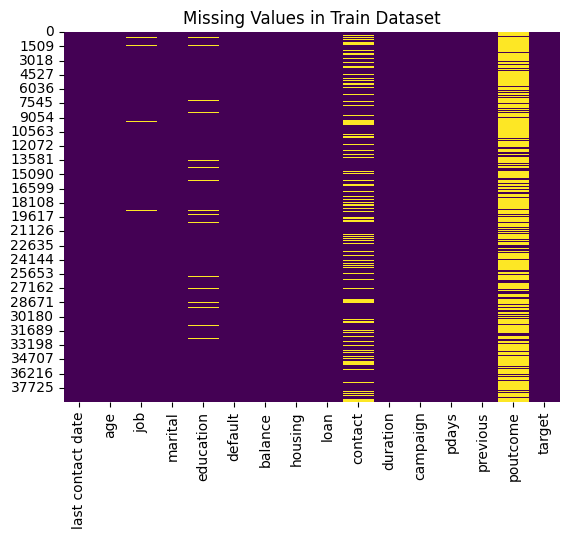

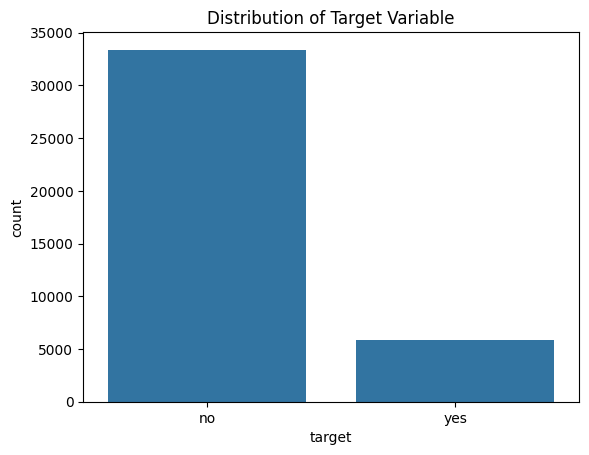

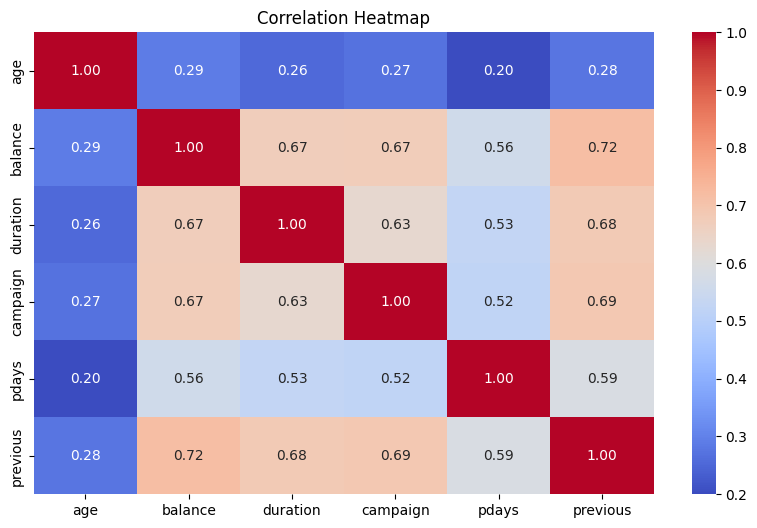

/tmp/ipykernel_15617/4078252629.py:53: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
/tmp/ipykernel_15617/4078252629.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/thusharkn/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:51:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/thusharkn/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:51:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/thusharkn/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:51:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/thusharkn/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:51:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/thusharkn/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:51:11] WARNING

KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# EDA and Insights
stats = train.describe()
print("Train Data Info:")
print(train.info())
print("\nTest Data Info:")
print(test.info())

# Check missing values
print("\nMissing Values in Train:")
print(train.isnull().sum())
print("\nMissing Values in Test:")
print(test.isnull().sum())

# Visualizations
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Train Dataset")
plt.show()

sns.countplot(data=train, x='target')
plt.title("Distribution of Target Variable")
plt.show()

# Correlation heatmap for numerical features
numerical_columns = train.select_dtypes(include=["number"])

if not numerical_columns.empty:
    plt.figure(figsize=(10, 6))
    sns.heatmap(numerical_columns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("No numerical columns found for correlation heatmap.")

# Fill missing values
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

for col in train.select_dtypes(include='object').columns:
    train[col].fillna(train[col].mode()[0], inplace=True)
    if col in test.columns:
        test[col].fillna(test[col].mode()[0], inplace=True)

# Encode target and categorical features
y_train = train['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_train = train.drop(['target'], axis=1)

label_encoders = {}
for col in X_train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    if col in test.columns:
        test[col] = test[col].map(lambda s: le.classes_.tolist().index(s) if s in le.classes_ else -1)
    label_encoders[col] = le

# Split train data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# XGBoost Classifier with Hyperparameter Tuning
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1
)

grid_search_xgb.fit(X_train_split, y_train_split)

# Best XGBoost Model
best_xgb_model = grid_search_xgb.best_estimator_
print(f"Best Parameters for XGBoost: {grid_search_xgb.best_params_}")

# Train XGBoost Model
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', best_xgb_model)
])

xgb_pipeline.fit(X_train_split, y_train_split)

# Validation Metrics
y_val_pred = xgb_pipeline.predict(X_val_split)
print("\nXGBoost Classification Report on Validation Set:")
print(classification_report(y_val_split, y_val_pred))

# Predict on training data
y_train_pred = xgb_pipeline.predict(X_train_split)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Predict on validation data
y_val_pred = xgb_pipeline.predict(X_val_split)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute metrics
train_f1 = f1_score(y_train_split, y_train_pred_binary, average='macro')
train_accuracy = accuracy_score(y_train_split, y_train_pred_binary)
validation_f1 = f1_score(y_val_split, y_val_pred_binary, average='macro')

# Print results
print(f"Train F1 Score (macro): {train_f1:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation F1 Score (macro): {validation_f1:.4f}")

# Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=best_xgb_model.feature_importances_, y=X_train.columns)
plt.title("XGBoost Feature Importances")
plt.show()

# Predict on Test Data
y_test_pred = xgb_pipeline.predict(test)
submission = pd.DataFrame({'id': range(len(y_test_pred)), 'target': ['yes' if y == 1 else 'no' for y in y_test_pred]})
submission.to_csv('submission_xgb.csv', index=False)
